# Compare aligned spike and template shapes

author: steeve.laquitaine@epfl.ch

Method:  

0. engineering spike instance dataset with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'
1. choose a channel
2. find nearby ground truth cells (within 40 microns of the channel)
3. reduce dimensionality of spikes and universal templates
4. plot univ. templates, missed sparse cells, detected sparse cells on the reduced space

note: we flip the templates and explained variance is normalized by the squared norm of the spike snippet ||D||**2.

## Setup

Virtual env is `env_kilosort_silico`

You should have extracted the templates from a KS3 run by running `python3.9 -m src.pipes.postpro.univ_temp` in the terminal before. See usage in `univ_temp` module.


In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)


# SETUP PROJECT PACKAGE
from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.pipes.postpro import univ_temp
from src.nodes.postpro import reduction
from src.nodes.postpro import template_matching as temp_match
from src.nodes.postpro.template_matching import get_rsquared

# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study'
SAMPLING_FREQ = 10000 # sample/sec
EXAMPLE_CELL_ID = 4209594
EXAMPLE_CHANNEL_ID = 20
MS_BEFORE = 9  # duration of snippet portion extracted from recording before true timestamp (ms)
MS_AFTER = 9   # duration of snippet portion extracted from recording after true timestamp (ms)
SNIPPET_DURATION = 6 # duration of snippet to project (ms)
CELL_TYPE = "PYR"
LOAD_WAVEFORM_EXTRACTOR = False
LOAD_GROUND_TRUTH = True
LOAD_PREP_TRACE = True


# SET CHANNEL AND NEAREST CELLS
NEAREST_CHANNEL = 30
MISSED_CELL_IDS = [165135, 288502, 273515, 288502, 342702, 37423, 39862, 424433]
DETECTED_CELL_IDS = [19690, 367098]  


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["postprocessing"]["shape_study"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["postprocessing"]["shape_study"]["nearest_channel"]


# SET PLOT PARAMETERS
N_TOTAL_COLORS = 30
N_DETECTED_COLORS = 15
colors = np.array(sns.color_palette('tab10', n_colors=N_TOTAL_COLORS))
detected_colors = colors[:N_DETECTED_COLORS,]
missed_colors = colors[N_DETECTED_COLORS:,]

2023-05-23 17:41:10,089 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-23 17:41:10,133 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-05-23 17:41:10,358 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-23 17:41:10,388 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Load spike data

0. spike instance dataset was engineered with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'

In [2]:
# load spike data
all_instances = pd.read_pickle(INSTANCE_FILE_PATH)
channel_ids = pd.read_pickle(CHANNEL_IDS_FILE_PATH)
cells = pd.read_pickle(CELL_LABELS_FILE_PATH)
spike_status = pd.read_pickle(SPIKE_STATUS_FILE_PATH)
nearest_channel = pd.read_pickle(NEAREST_CHANNEL_FILE_PATH)

## Check templates, the spikes of missed and detected cell

spike count: 66
2023-05-23 17:41:13,571 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-23 17:41:13,607 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0
spike count: 5
2023-05-23 17:41:13,736 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-23 17:41:13,751 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


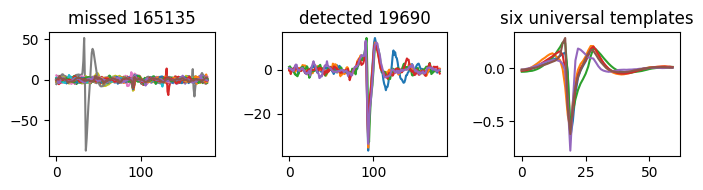

In [3]:
# set parameters
NEAREST_CHANNEL = 30
MISSED_CELL = 165135
#MISSED_CELL = 37423
DETECTED_CELL = 19690

# setup plots
fig, axes = plt.subplots(1,3, figsize=(7,2))

# plot a missed sparse cell
missed_cell_instances = all_instances.iloc[np.where((cells.values==MISSED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[0].plot(missed_cell_instances.T);
axes[0].set_title(f"missed {MISSED_CELL}");
print("spike count:", missed_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[MISSED_CELL] == missed_cell_instances.shape[0], "spike count does not make sense"

# plot a detected sparse cell
detected_cell_instances = all_instances.iloc[np.where((cells.values==DETECTED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[1].plot(detected_cell_instances.T);
axes[1].set_title(f"detected {DETECTED_CELL}");

print("spike count:", detected_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[DETECTED_CELL] == detected_cell_instances.shape[0], "spike count does not make sense"

# plot Kilosort3's six universal templates
univ_templates = univ_temp.load(data_conf)
univ_templates = univ_templates.T[:,:-1]
univ_templates = univ_templates
axes[2].plot(univ_templates.T);
axes[2].set_title("six universal templates");

plt.tight_layout()

## Template-match spikes

Template alignment can position template far from ground truth spike timestamp, more so when spike snippet period is long, and other spikes occur within the period. To make sure that we capture the ground truth spike's signal and not noise or another spike, we selected the max explained variance of the template fit to the signal within a narrow window centered on the ground truth spike timestamp.

TODO:
- constrain the maximization of explained variance in a more restricted neighborhood (about the duration of a cell's refractory period, g., -/+1 ms) centered on the ground truth spike's timestamp to avoid extracting other spike signals, that would be better fitted than our target spike signal.

## Plot best-fitted instances of template 1 and best-matched signals (detected spikes) in 2D

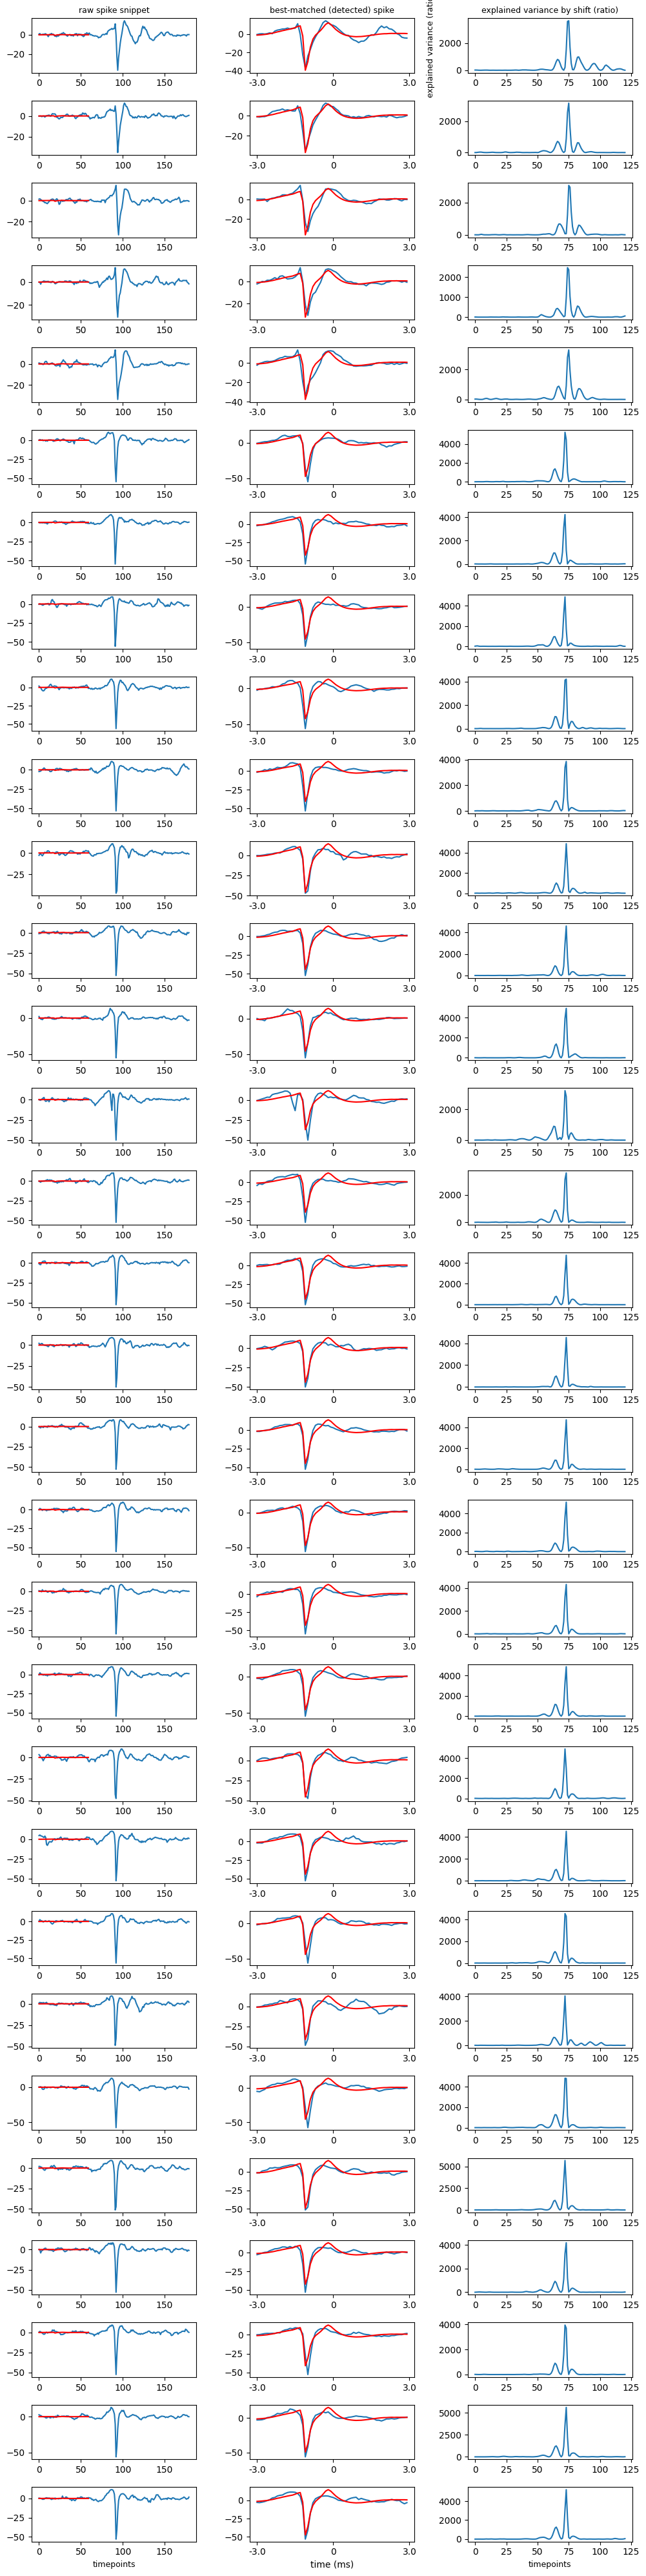

In [4]:
# get all detected spikes (instances x timepoints)
detected_loc = np.where((cells.values==DETECTED_CELL_IDS) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()
detected_instances = all_instances.iloc[detected_loc,:]

# apply template matching (convolution)
extracted_detected_spikes, best_fit_temps_to_detected_spikes, max_explained_var_for_detected, best_fit_shifts, fig = temp_match.template_match(
    detected_instances,
    univ_templates[0],
    neighborhood=(6,9), 
    timepoints_before=30,
    timepoints_after=30,
    sampling_freq=10000,
    figsize=(10,40)).values()

# calculate spike snippet duration we want to dim-reduce in (ms)
spike_snippet_duration = SNIPPET_DURATION * SAMPLING_FREQ / 1000

# sanity checks
# check that spike snippets and template have the correct duration
assert extracted_detected_spikes.shape[1] == best_fit_temps_to_detected_spikes.shape[1] == spike_snippet_duration

# check shift is in correct neighborhood
neighbh_start_tpoints = int(6*SAMPLING_FREQ/1000)
neighbh_end_tpoints =  int(9*SAMPLING_FREQ/1000)
assert all((np.array(best_fit_shifts)>=neighbh_start_tpoints) & (np.array(best_fit_shifts)<=neighbh_end_tpoints)), "a best fit shift is not within the restricted neighborhood of the true timestamp as enforced"

# check explained variance within [0,1]
# assert all((max_explained_var_for_detected >=0) & (max_explained_var_for_detected <=1))


TODO:  
- position raw template at its aligned position in column 1 of the figure to see where it best fits the signal.
- parametrize template_match with ms instead of timepoints

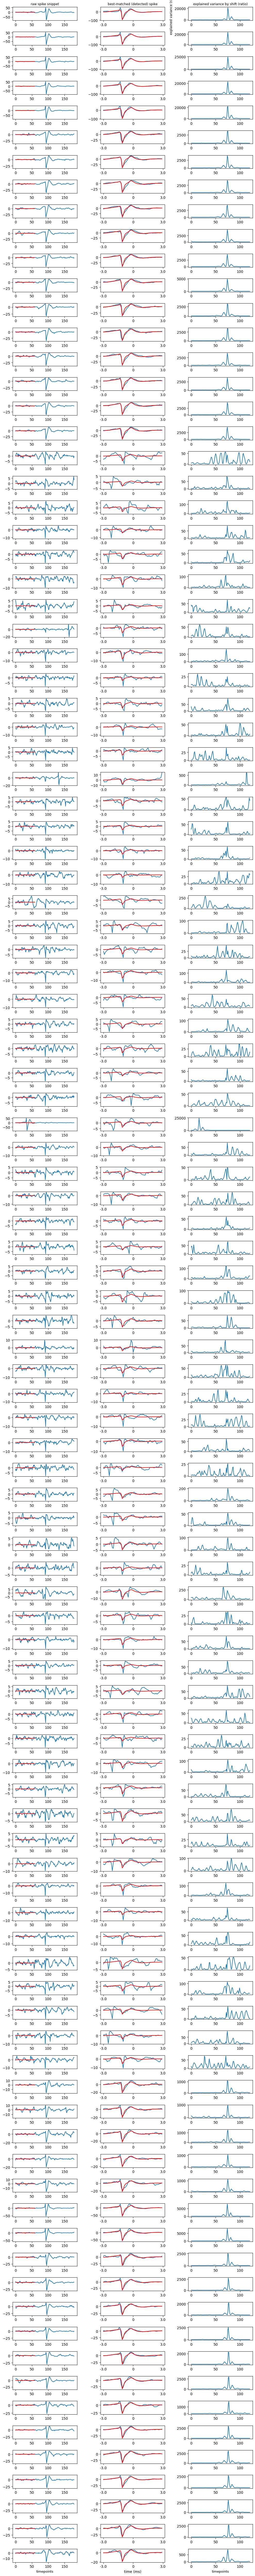

In [5]:
# get all missed spikes (instances x timepoints)
missed_sparse_loc = np.where((cells.values==MISSED_CELL_IDS) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()
missed_sparse_instances = all_instances.iloc[missed_sparse_loc,:]

# apply template matching
extracted_missed_spikes, best_fit_temps_to_missed_spikes, max_explained_var_for_missed, best_fit_shifts, fig = temp_match.template_match(
    missed_sparse_instances,
    univ_templates[0],
    neighborhood=(6,9), 
    timepoints_before=30,
    timepoints_after=30,
    sampling_freq=10000,
    figsize=(10,100)).values()

# sanity checks
# check correct duration
assert extracted_missed_spikes.shape[1] == best_fit_temps_to_missed_spikes.shape[1] == spike_snippet_duration, "spike snippets and template do not have the correct duration"

# check shift is in correct neighborhood
neighbh_start_tpoints = int(6*SAMPLING_FREQ/1000)
neighbh_end_tpoints =  int(9*SAMPLING_FREQ/1000)
assert all((np.array(best_fit_shifts)>=neighbh_start_tpoints) & (np.array(best_fit_shifts)<=neighbh_end_tpoints)), "a best fit shift is not within the restricted neighborhood of the true timestamp as enforced"

# check explained variance within [0,1]
# assert all((max_explained_var_for_missed >=0) & (max_explained_var_for_missed <=1))

## Fit templates to spikes via projection

In [6]:
def get_cell_labels(cells, channel_ids, spike_status, missed_ids, detected_ids, nearest_channel):
    
    # get missed cell labels
    loc = np.where((cells.values==missed_ids) & (channel_ids.values==nearest_channel) & (spike_status.values==True))[0].tolist()
    missed_cells = cells.values[loc]

    # get detected cell labels
    loc = np.where((cells.values==detected_ids) & (channel_ids.values==nearest_channel) & (spike_status.values==True))[0].tolist()
    detected_cells = cells.values[loc]
    return detected_cells, missed_cells

## Plot fitted template and its matched signal (detected spike)

note: scaling a template translates its coordinates along a line (red crosses) in the reduced 2D pca space. This makes sense.

In [7]:
# format instances to dim-reduce
instances = np.vstack([extracted_detected_spikes, extracted_missed_spikes])
template_fits = np.vstack([best_fit_temps_to_detected_spikes, best_fit_temps_to_missed_spikes])

# get all labels
# get cell labels
detected_cells, missed_cells = get_cell_labels(cells, channel_ids, spike_status, MISSED_CELL_IDS, DETECTED_CELL_IDS, NEAREST_CHANNEL)
template_label = np.vstack([detected_cells, missed_cells])

# get gids
raw_cell_labels = np.vstack([detected_cells, missed_cells, template_label])

# convert gids to number id from 0 to N units
cell_labels = np.unique(raw_cell_labels, axis=0, return_inverse=True)[1]

# get detection labels
detection_labels = np.sum(raw_cell_labels == DETECTED_CELL_IDS, axis=1)

# get explained variance
explained_var = np.hstack([max_explained_var_for_detected, max_explained_var_for_missed]) 

# sanity check
assert instances.shape[0]*2==cell_labels.shape[0]==detection_labels.shape[0], "instances, cell_labels and detection_labels shape differ"

Hypothesis:

- The more component 2 (likely spike's first positive peak) contributes to spike shape (is pronounced) and the more likely it is that the spike will be missed (see cells 2, 1 and 5 in order).
- Component 1 is likely the spike's negative peak.


TODO:
- in the current code, a cell is detected if at least one of its spike is detected and all its spikes are legended with a filled color. Further, distinguish for each cell, the detected spikes from the missed ones -> Just fill the dot if detected, leave it empty if not detected, make sure all cell have different colors.
- component1 seem to increases with an increase in the spike negative peak amplitude. Should spikes be unit-normed to capture only changes related with shape and not SNR-related.
- component2 actually explains only 6% of variance which is 12 X less than component 1. The plot should communicate that info.
- plot component1 and 2 to see what they look like.
- test CEBRA, which does not lose information contrary to PCA. tsne distances are not meaningful to measure shape difference.
- is cell 37423 detected then dropped in Kilosort3? How can it be far from its template fit but still have high r-square? We might need to normalize each dot. Dot location currently change with spike amplitude after PCA. We only want it to depend on the proportions of component 1 and 2, not on their absolute amount of explained variance. Should we renormalize the observations in the new feature space after PCA to compare distances? Currently R-squared seems to be predicted by component 1, not 2. 
The R-square does not change when we scale spike and template amplitudes, for a fixed shape, because it is a normalized metric (it is the Sum of squared error between the spike and template fit normalized by the sum of squared error to the mean of the spikes (Sum of square total SST). 1-SSE/SST).

2023-05-23 17:41:58,190 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_silico/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_silico/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


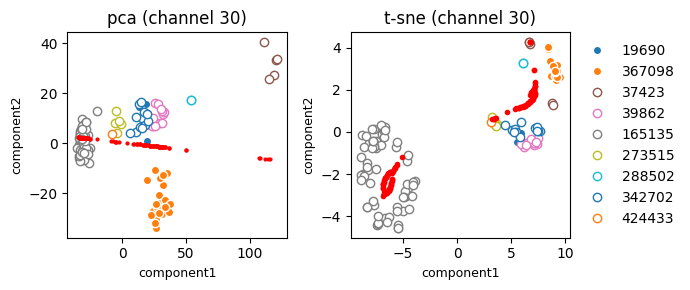

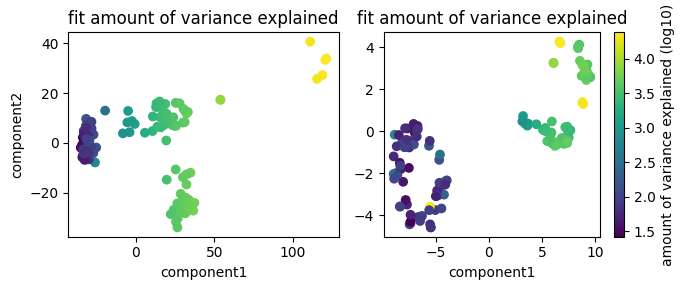

In [8]:
# setup plot
fig, axes = plt.subplots(1,2, figsize=(7,3))

# apply dim. reductions
pca_embedding, pca_model = reduction.pca_spikes_and_template_fits(axis=axes[0], spike_instances=instances, template_fits=template_fits, labels=raw_cell_labels, detection_status=detection_labels, detected_colors=detected_colors, missed_colors=missed_colors)
tsne_embedding, tsne_model = reduction.tsne_spikes_and_template_fits(axis=axes[1], spike_instances=instances, template_fits=template_fits, labels=raw_cell_labels, detection_status=detection_labels, detected_colors=detected_colors, missed_colors=missed_colors)

# legend
axes[0].set_title(f"pca (channel {NEAREST_CHANNEL})")
axes[1].set_title(f"t-sne (channel {NEAREST_CHANNEL})")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
plt.tight_layout()

# scatter plot with colored dots
fig, axes = plt.subplots(1,2, figsize=(7,3))
mappable = axes[0].scatter(pca_embedding[:len(instances),0], pca_embedding[:len(instances),1], c=np.log10(explained_var), cmap="viridis")
mappable = axes[1].scatter(tsne_embedding[:len(instances),0], tsne_embedding[:len(instances),1], c=np.log10(explained_var), cmap="viridis")

# legend
axes[0].set_title(f"fit amount of variance explained")
axes[0].set_xlabel("component1")
axes[0].set_ylabel("component2")
axes[1].set_title(f"fit amount of variance explained")
axes[1].set_xlabel("component1")

plt.colorbar(mappable, label="amount of variance explained (log10)")
plt.tight_layout()

## Get PCA model fit quality: explained variance

In [9]:
print("pca's explained variance by component:", pca_model.explained_variance_ratio_)
print("total explained variance:", sum(pca_model.explained_variance_ratio_))

pca's explained variance by component: [0.8166208 0.0645485]
total explained variance: 0.8811693266034126


## Check

In [29]:
def simulate_rsquared(eigenval1, eigenval2, comp1, comp2, template):

    # generate a spike
    spike = eigenval1*comp1 + eigenval2*comp2

    # fit template
    amplitude_x = template @ spike
    fitted_template = amplitude_x * template

    # calculate fit r-squared
    return get_rsquared(np.array([spike]), np.array([fitted_template]))[0]

def get_reconstructed_rsquared(cell, embed, cell_label, model):

    # number of examples to plot
    N_EXAMPLES = 5

    n_spikes = int(len(embed)/2)

    spike_embed = embed[:n_spikes]
    cell_label_for_spikes = cell_label[:n_spikes]

    # get cell spikes eigenvalues
    cell_spike_eigenvalue = spike_embed[(cell_label_for_spikes==cell).squeeze(), :]

    # multiply by eigenvectors to reconstruct
    reconstructed_spikes = (cell_spike_eigenvalue @ model.components_)

    # reconstruct template fits
    template_embed = embed[n_spikes:]
    cell_label_for_template = cell_label[n_spikes:]

    # get cell spikes eigenvalues
    cell_template_eigenvalue = template_embed[(cell_label_for_template==cell).squeeze(), :]

    # multiply by eigenvectors to reconstruct
    reconstructed_template = (cell_template_eigenvalue @ model.components_)

    # setup plot
    _, axes = plt.subplots(1, min(len(reconstructed_spikes), N_EXAMPLES), figsize=(8,2))
    
    for s_i, spike_i in enumerate(reconstructed_spikes[:N_EXAMPLES]):
        
        # plot 
        axes[s_i].plot(spike_i);
        axes[s_i].plot(reconstructed_template[s_i], "r");
        # if s_i==0:
        #     axes[0].set_title("reconstructed spike and template fit")
    plt.tight_layout()
    return get_rsquared(reconstructed_spikes, reconstructed_template)

def get_true_rsquared_and_plot_fits(cell, instances, template_fits, cell_label):

    # number of examples to plot
    N_EXAMPLES = 5

    n_spikes = len(instances)

    cell_label_for_spikes = cell_label[:n_spikes]

    # get cell spikes eigenvalues
    cell_spikes = instances[(cell_label_for_spikes==cell).squeeze(), :]

    # reconstruct template fits
    cell_label_for_template = cell_label[n_spikes:]

    # get cell spikes eigenvalues
    cell_template_fits = template_fits[(cell_label_for_template==cell).squeeze(), :]

    # setup plot
    _, axes = plt.subplots(1, min(len(cell_spikes), N_EXAMPLES), figsize=(8,2))
    
    for s_i, spike_i in enumerate(cell_spikes[:N_EXAMPLES]):
        
        # plot 
        axes[s_i].plot(spike_i);
        axes[s_i].plot(cell_template_fits[s_i], "r");
        # if s_i==0:
        #     axes[0].set_title("reconstructed spike and template fit")
    plt.tight_layout()
    return get_rsquared(cell_spikes, cell_template_fits)

### Disambiguate the contribution of the shape components to template fit ($R^2$)

Visualize the two main shape components

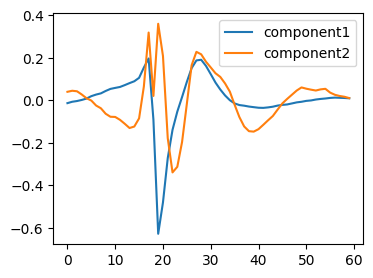

In [33]:
# plot unit-normed first two principal components (eigenvectors)
fig, axes = plt.subplots(1,1, figsize=(4,3))
axes.plot(pca_model.components_.T);
plt.legend(["component1", "component2"]);

Calculate proportion of template fit's explained variance ($R^2$)

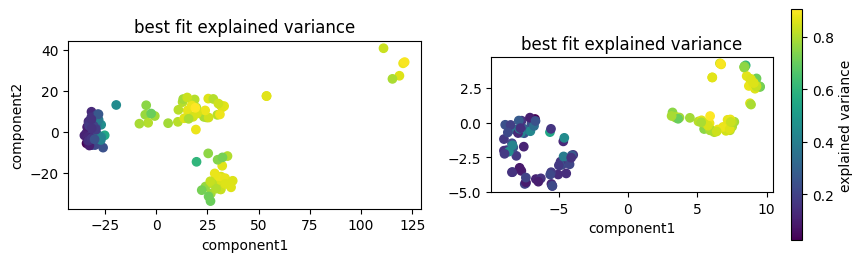

In [10]:
# calculate r-squared 
rsquared = get_rsquared(instances, template_fits)

# scatter plot with colored dots
fig, axes = plt.subplots(1,2, figsize=(10,3))

# plot pca
mappable = axes[0].scatter(pca_embedding[:len(instances),0], pca_embedding[:len(instances),1], c=rsquared, cmap="viridis")
axes[0].set_title(f"best fit explained variance")
axes[0].set_xlabel("component1")
axes[0].set_ylabel("component2")
axes[0].axis("scaled");

# plot tsne
mappable = axes[1].scatter(tsne_embedding[:len(instances),0], tsne_embedding[:len(instances),1], c=rsquared, cmap="viridis")
axes[1].set_title(f"best fit explained variance")
axes[1].set_xlabel("component1")
plt.colorbar(mappable, label="explained variance")
axes[1].axis("scaled");

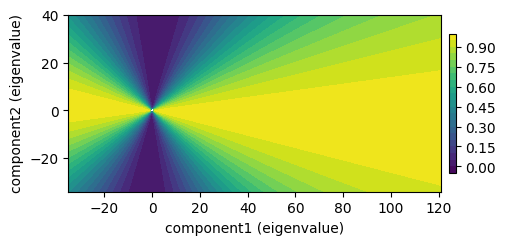

In [31]:
# both are unit-normed, comp1 is kept fixed and comp2 increases
# get shape components (eigenvectors)
comp1 = pca_model.components_[0]
comp2 = pca_model.components_[1]

# get first template
template_1 = univ_templates[0]

# calculate plot x and ylims
min_comp1_eigenval = np.floor(pca_embedding[:,0].min())
min_comp2_eigenval = np.floor(pca_embedding[:,1].min())
max_comp1_eigenval = np.ceil(pca_embedding[:,0].max())
max_comp2_eigenval = np.ceil(pca_embedding[:,1].max())

# create eigenvalues to test
comp1_axis = np.arange(int(min_comp1_eigenval), int(max_comp1_eigenval), 1)
comp2_axis = np.arange(int(min_comp2_eigenval), int(max_comp2_eigenval), 1)

# calculate r-squared
rsquared = np.zeros((len(comp1_axis), len(comp2_axis)))*np.nan

for ix in range(len(comp1_axis)):
    for jx in range(len(comp2_axis)):
        rsquared[ix, jx] = simulate_rsquared(comp1_axis[ix], comp2_axis[jx], comp1, comp2, template_1)

# create grid of x,y-axes eigenvalues to plot
comp1_eigenvals, comp2_eigenvals = np.meshgrid(comp1_axis, comp2_axis)

fig, axes = plt.subplots(1,1, figsize=(5,3))

# plot r-squared
im = plt.contourf(comp1_eigenvals, comp2_eigenvals, rsquared.T, 20, cmap='viridis');
plt.axis("scaled");
plt.xlabel("component1 (eigenvalue)");
plt.ylabel("component2 (eigenvalue)");
plt.colorbar(im, fraction=0.018, pad=0.02);

In [11]:
# check r-squared for two detected and the missed 37423 -> missed has higher r-squared values (unexpected)
rsq_19690 = np.array(rsquared)[(raw_cell_labels[:len(instances)]==19690).squeeze()]
rsq_367098 = np.array(rsquared)[(raw_cell_labels[:len(instances)]==367098).squeeze()]
rsq_37423 = np.array(rsquared)[(raw_cell_labels[:len(instances)]==37423).squeeze()]
print(np.sort(rsq_19690))
print(np.sort(rsq_367098))
print(np.sort(rsq_37423))

[0.75377624 0.79480579 0.80835611 0.8099859  0.87935372]
[0.60284808 0.70446281 0.71128191 0.72170379 0.72171485 0.74263017
 0.75841657 0.76841169 0.78273698 0.8050587  0.80653486 0.81774792
 0.82241947 0.83036691 0.83038897 0.8339072  0.85607217 0.85841778
 0.85926514 0.86133328 0.86148888 0.86453449 0.86668224 0.87249668
 0.87604087 0.88135906]
[0.7961707  0.83502975 0.8592719  0.88194996 0.89969887]


### Get R2 for reconstructed reduced spikes and templates for cell 37423

[0.8443714875293908, 0.8975158726882752, 0.8963175065268147, 0.9221424519205651, 0.924930592392715]
[0.9192699282290062, 0.4787409660190993, 0.5972392386930614, 0.4193931035674835, 0.48549065110642897, 0.7147014632818782, 0.6236396033180647, 0.7054830167101788, 0.6685013452855985, 0.4130317484778061, 0.683767069550373, 0.7021895923752431, 0.6097877285843472, 0.7271099209192139, 0.5799527833156994, 0.5989298907018916, 0.8226446351677489, 0.5658701127679082, 0.8557325154346579, 0.43434810409729674, 0.8942108969046583, 0.747729995779635, 0.58332374032856, 0.8761315908640325, 0.6867088449117054, 0.6782578912719868]


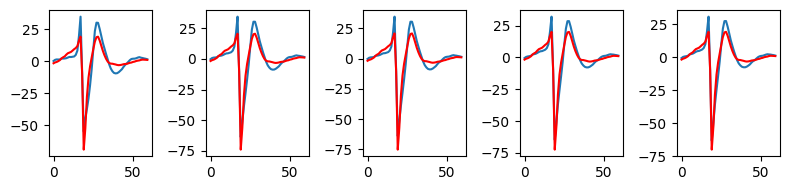

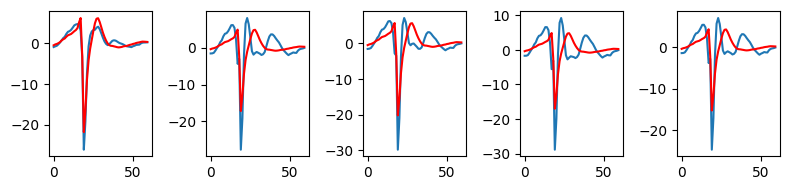

In [14]:
# get reconstructed rsquared for a detected and missed cell
CELL = 37423
print(get_reconstructed_rsquared(cell=CELL, embed=pca_embedding, cell_label=raw_cell_labels, model=pca_model))

CELL = 367098
print(get_reconstructed_rsquared(cell=CELL, embed=pca_embedding, cell_label=raw_cell_labels, model=pca_model))

### Compare with r-squared from true spike and template fit

[0.8350297451345954, 0.8819499597583813, 0.8996988686835884, 0.8592718977568596, 0.7961707007789155]
[0.8065348586290266, 0.782736982293405, 0.8303889679738559, 0.7044628134101013, 0.7684116908408029, 0.8584177806134511, 0.8224194736181265, 0.8613332839139536, 0.6028480773448803, 0.7217037945424003, 0.8813590616983317, 0.8760408738911617, 0.8560721736629031, 0.8724966809697358, 0.8177479223885511, 0.8339072021285784, 0.8666822406767888, 0.8050586987735919, 0.7426301706034786, 0.7112819054859776, 0.7217148543986398, 0.8614888811285497, 0.8303669063768213, 0.7584165713638447, 0.8645344943727611, 0.8592651427240183]


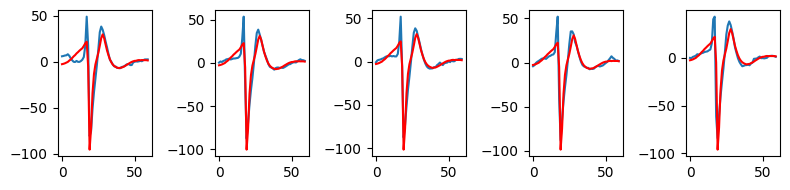

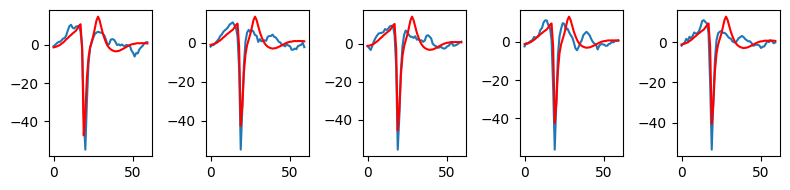

In [16]:
# get raw rsquared for a detected and missed cell
CELL = 37423
print(get_true_rsquared_and_plot_fits(CELL, instances, template_fits, raw_cell_labels))

CELL = 367098
print(get_true_rsquared_and_plot_fits(CELL, instances, template_fits, raw_cell_labels))

Can we show that r-square increases with the amplitude of component 1?
- extract both components vectors and use them to compose new spikes with increasing proportion of component 1, fit template and measure r-squared. I expect r-square to increase.
- repeat for component 2: I expect r-square to decrease.

## Disambiguate shape component contributions to the r-squared

These two plots correspond to a slice at 1 on the component1 (eigenvalue=1) x-axis on the pca plot and a slice at 1 on the component2 (eigenvalue=1) y-axis

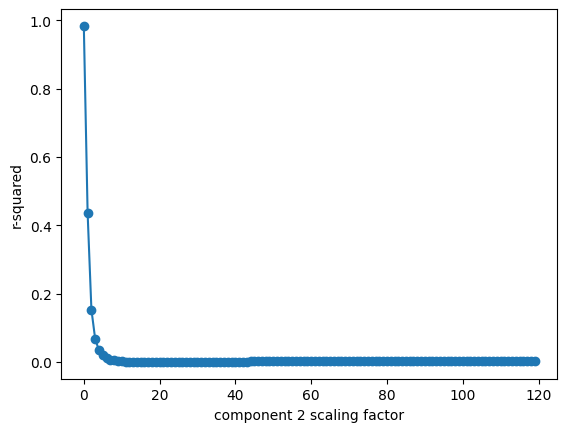

In [17]:
# both are unit-normed, comp1 is kept fixed and comp2 increases
# get shape components (eigenvectors)
comp1 = pca_model.components_[0]
comp2 = pca_model.components_[1]

# set test contributions
comp2_ratio = np.arange(0,120,1)

spikes = []
for ratio in comp2_ratio:
    spikes.append(comp1 + ratio*comp2)

rsquared = []

for spike in spikes:

    # template match spike and template
    amplitude_x = template_1 @ spike
    fitted_template = amplitude_x * template_1

    # calculate r-squared
    rsquared.append(get_rsquared(np.array([spike]),np.array([fitted_template])))

plt.plot(comp2_ratio, rsquared, "-o");
plt.ylabel("r-squared");
plt.xlabel("component 2 scaling factor");

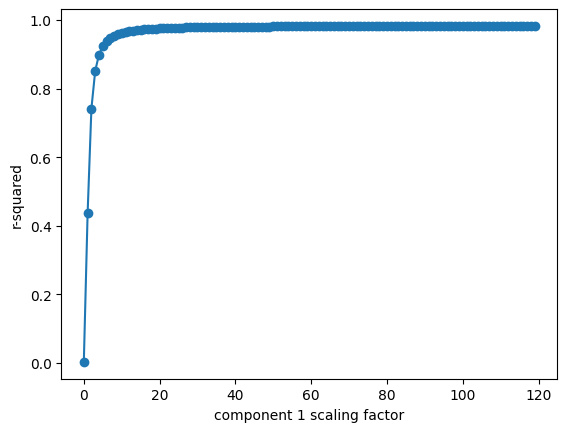

In [18]:
# set test contributions
comp1_ratio = np.arange(0,120,1)

spikes = []
for ratio in comp1_ratio:
    spikes.append(ratio*comp1 + comp2)

rsquared = []

for spike in spikes:

    # template match spike and template
    amplitude_x = template_1 @ spike
    fitted_template = amplitude_x * template_1

    # calculate r-squared
    rsquared.append(get_rsquared(np.array([spike]), np.array([fitted_template])))

plt.plot(comp1_ratio, rsquared, "-o");
plt.ylabel("r-squared");
plt.xlabel("component 1 scaling factor");

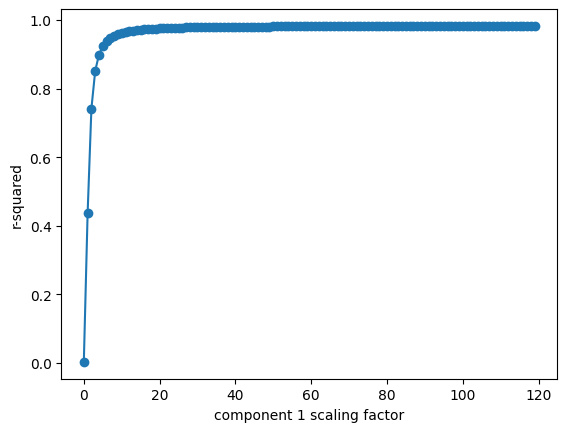

In [19]:
# both are unit-normed, comp1 is kept fixed and comp2 increases
# get shape components (eigenvectors)
comp1 = pca_model.components_[0]
comp2 = pca_model.components_[1]

# set test contributions
comp1_ratio = np.arange(0,120,1)

spikes = []
for ratio in comp1_ratio:
    spikes.append(ratio*comp1 + comp2)

rsquared = []

for spike in spikes:

    # template match spike and template
    amplitude_x = template_1 @ spike
    fitted_template = amplitude_x * template_1

    # calculate r-squared
    rsquared.append(get_rsquared(np.array([spike]), np.array([fitted_template])))

plt.plot(comp1_ratio, rsquared, "-o");
plt.ylabel("r-squared");
plt.xlabel("component 1 scaling factor");

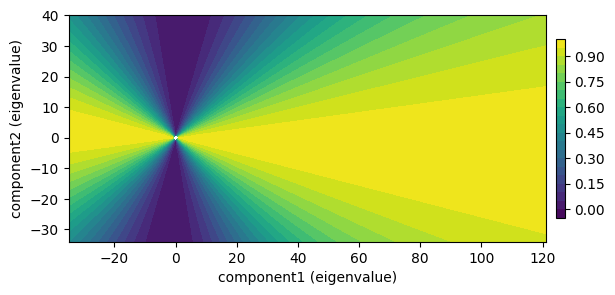

Component2 contributes a lot to cell 37423' spikes compared to all other cell spikes. Why doesn't its contribution to cell 37423's spikes lower the r-squared below the other cells r-squared?

Hyp: because component 1's contribution to cell 37423's spikes is much larger than to other cells and to component2 and enables sufficiently large r-squared to compensate the decrease caused by component 2. 

## Check fit by cell and detection status

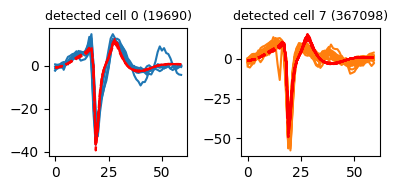

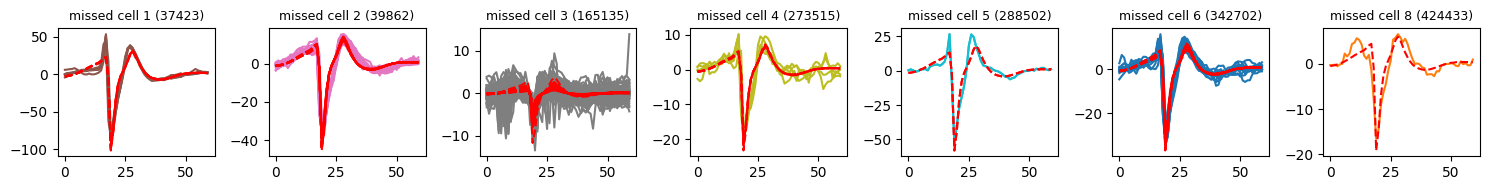

In [86]:
# plot detected cell spikes
detected_labels = np.unique(cell_labels[np.where(detection_labels==1)[0]])
fig, axes = plt.subplots(1,len(detected_labels), figsize=(4,2))

# get number id
spike_cell_labels = cell_labels[:len(instances)]

# get gid
raw_spike_cell_labels = raw_cell_labels[:len(instances)]

# get cell number ids of template fits
template_cell_labels = cell_labels[len(instances):]

for ix, label_i in enumerate(detected_labels):
    
    # locate this cell's spikes
    cell_loc = spike_cell_labels==label_i
    
    # get cell gid
    cell_gid = raw_spike_cell_labels[cell_loc][0][0]

    # plot cell's spikes
    axes[ix].plot(instances[cell_loc].T, color=detected_colors[ix,:]);

    # plot spikes' template fits
    axes[ix].plot(template_fits[template_cell_labels==label_i].T, "--r");

    # legend 
    axes[ix].set_title(f"detected cell {label_i} ({cell_gid})", fontsize=9)
plt.tight_layout()

# plot missed cell spikes
missed_labels = np.unique(cell_labels[np.where(detection_labels==0)[0]])
fig, axes = plt.subplots(1,len(missed_labels), figsize=(15,2))

for ix, label_i in enumerate(missed_labels):

    # locate this cell's spikes
    cell_loc = spike_cell_labels==label_i
    
    # get cell gid
    cell_gid = raw_spike_cell_labels[cell_loc][0][0]

    # plot cell's spikes
    axes[ix].plot(instances[cell_loc].T, color=missed_colors[ix,:]);
    
    # plot spikes' template fits
    axes[ix].plot(template_fits[template_cell_labels==label_i].T, "--r");

    # legend
    axes[ix].set_title(f"missed cell {label_i} ({cell_gid})", fontsize=9)
plt.tight_layout()

## Check spike-template fit mapping

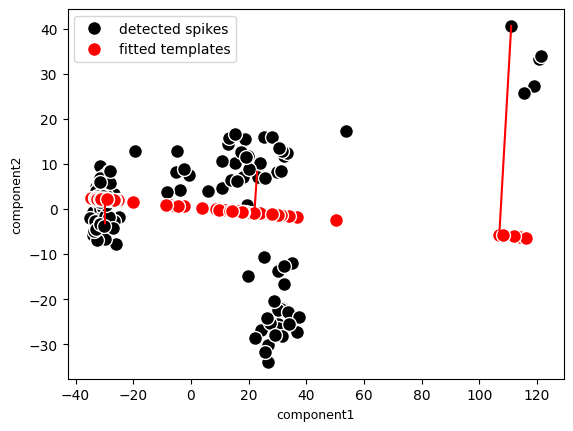

In [83]:
# map three examples of detected spikes and their fitted template
fig, ax = plt.subplots(1,1)
label=3
label_loc = cell_labels == label
x = pca_embedding[:len(instances),0]
y = pca_embedding[:len(instances),1]

# plot detected spike
ax.plot(
    x,
    y,
    marker="o",
    color="k",
    linestyle="none",
    label="detected spikes",
    markeredgecolor="w",
    markersize=10
)

# plot fitted template
ax.plot(
    pca_embedding[len(instances):,0],
    pca_embedding[len(instances):,1],
    marker="o",
    color="r",
    linestyle="none",
    label="fitted templates",
    markeredgecolor="w",
    markersize=10
)

# link the detected spike with its fitted template with a red line
# spike instance 0
plt.plot(
    [pca_embedding[:len(instances),0][0], pca_embedding[len(instances):,0][0]],
    [pca_embedding[:len(instances),1][0], pca_embedding[len(instances):,1][0]]
    , "r", linestyle="-")

# spike instance 31
plt.plot(
    [pca_embedding[:len(instances),0][31], pca_embedding[len(instances):,0][31]],
    [pca_embedding[:len(instances),1][31], pca_embedding[len(instances):,1][31]]
    , "r", linestyle="-")

# spike instance 100
plt.plot(
    [pca_embedding[:len(instances),0][100], pca_embedding[len(instances):,0][100]],
    [pca_embedding[:len(instances),1][100], pca_embedding[len(instances):,1][100]]
    , "r", linestyle="-")

# legend
ax.set_xlabel("component1", fontsize=9);
ax.set_ylabel("component2", fontsize=9);
plt.legend();

# References

[A refresher on convolution and crosscorrelation](https://www.youtube.com/watch?v=C3EEy8adxvc)

[Reverse PCA and reconstruct original variables](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com)